Index(['Unnamed: 0', 'Time Serie', 'AUSTRALIA - AUSTRALIAN DOLLAR/US$',
       'EURO AREA - EURO/US$', 'NEW ZEALAND - NEW ZELAND DOLLAR/US$',
       'UNITED KINGDOM - UNITED KINGDOM POUND/US$', 'BRAZIL - REAL/US$',
       'CANADA - CANADIAN DOLLAR/US$', 'CHINA - YUAN/US$',
       'HONG KONG - HONG KONG DOLLAR/US$', 'INDIA - INDIAN RUPEE/US$',
       'KOREA - WON/US$', 'MEXICO - MEXICAN PESO/US$',
       'SOUTH AFRICA - RAND/US$', 'SINGAPORE - SINGAPORE DOLLAR/US$',
       'DENMARK - DANISH KRONE/US$', 'JAPAN - YEN/US$',
       'MALAYSIA - RINGGIT/US$', 'NORWAY - NORWEGIAN KRONE/US$',
       'SWEDEN - KRONA/US$', 'SRI LANKA - SRI LANKAN RUPEE/US$',
       'SWITZERLAND - FRANC/US$', 'TAIWAN - NEW TAIWAN DOLLAR/US$',
       'THAILAND - BAHT/US$'],
      dtype='object')


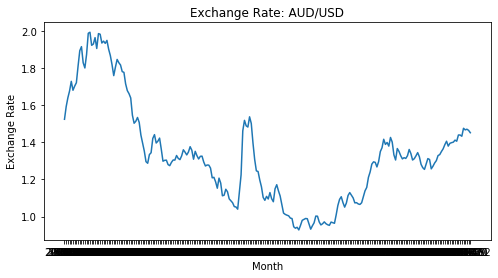

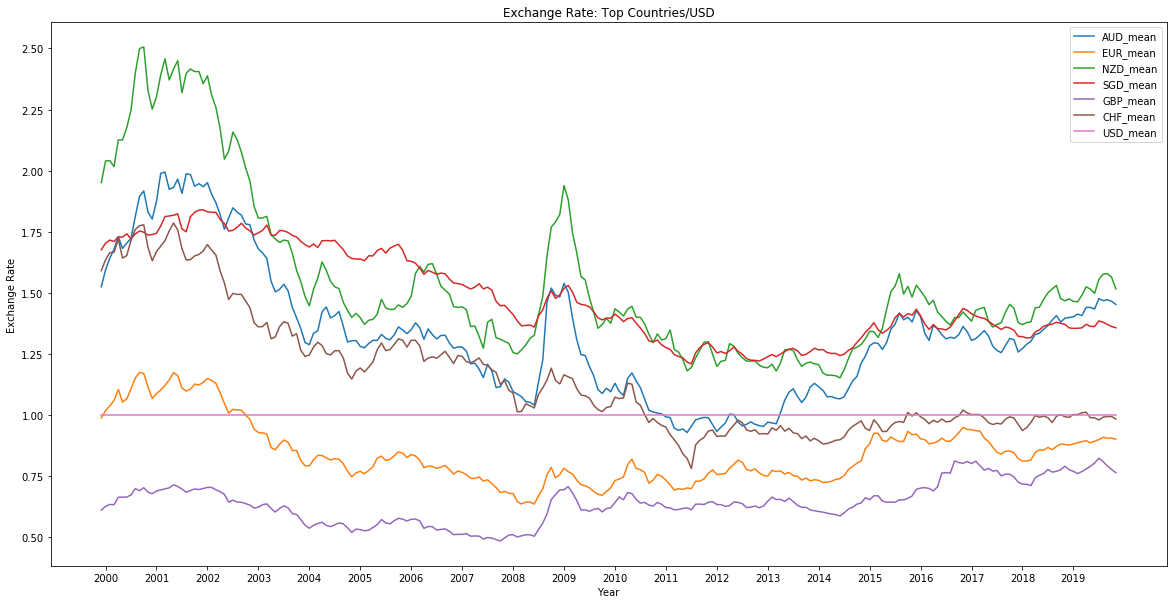

Loading BokehJS ...

      AUD_USD  SGD_USD
0      1.5172   1.6563
1      1.5239   1.6535
2      1.5267   1.6560
3      1.5291   1.6655
4      1.5272   1.6625
...       ...      ...
5010   1.4445   1.3550
5011   1.4411   1.3540
5012   1.4331   1.3520
5013   1.4278   1.3483
5014   1.4225   1.3446

[5015 rows x 2 columns]
18.44622546977485
stat=0.954, p=0.487
Probably Gaussian
stat=0.897, p=0.051
Probably Gaussian
stat=-0.013, p=0.960
Probably independent
stat=-2.325, p=0.026
Probably different distributions
0.0262041227


In [1]:
%run exchange-rate-prediction-part1.ipynb

In [2]:
#D. Machine Learning Models

In [3]:
ir_df = pd.read_csv("aud usd interest carry trade.csv")
ir_df.head()

#Source: https://forexop.com/swaps/AUDUSD/

,Date,Long Carry,Short Carry
0,2017-01-01,0.65%,-2.42%
1,2017-02-01,0.78%,-2.50%
2,2017-03-01,0.66%,-2.38%
3,2017-04-01,0.34%,-2.10%
4,2017-05-01,0.32%,-2.22%


In [4]:
#1. Linear Regression with 1 independent variable (interest rates)

#Date period: from 2017 to 2019

x_ir = ir_df['Long Carry'].astype(str)
x_ir = x_ir.replace({'%':''}, regex = True)
x_ir = x_ir.astype(float)
x_ir = np.array(x_ir).reshape(-1,1)

aud_usd_fx = df_groupby_aud[(df_groupby_aud['month_year'] >= '2017-01') & (df_groupby_aud['month_year'] <='2019-12')].reset_index(drop=True)
aud_usd = aud_usd_fx['AUD_USD']

y_fx = aud_usd

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

x_train, x_test, y_train, y_test = train_test_split(x_ir, y_fx, train_size=0.8, test_size=0.2, random_state=1)

model = LinearRegression()
model.fit(x_train, y_train)
y_predict = model.predict(x_test)
print(y_predict)

print("R-squared of training data is: " + str(model.score(x_train, y_train)))
print("R-squared of testing data is: " + str(model.score(x_test, y_test)))

[1.42759002 1.43493561 1.40922605 1.28496315 1.36454037 1.35474625
 1.3669889  1.38841354]
R-squared of training data is: 0.6947623687482268
R-squared of testing data is: 0.6776295453826162


In [6]:
#since the sample size is small (n=36), test the score of the entire sample against the train_test_split

model = LinearRegression()
model.fit(x_ir, y_fx)
y_fx_predict = model.predict(x_ir)

print("R-squared of the entire dataset is: " + str(model.score(x_ir, y_fx)))

#learning: train_test_split score of the training set is not significantly different from the score of the samples
#learning 2: as the sample dataset (2017-2019) is not representative of the entire period (2000-2019)
#and the size is relatively small, I will not split the data into train and test sets for simplicity
#and this is the regression model with time series, so I need full dataset for processing and visualisation

R-squared of the entire dataset is: 0.720032833933373


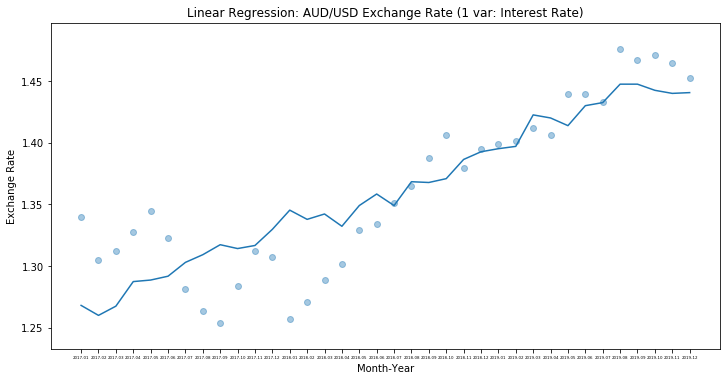

In [7]:
month_year = aud_usd_fx['month_year']
month_year = month_year.astype(str)

plt.figure(figsize=(12,6))
plt.scatter(month_year, y_fx, alpha=0.4)
plt.plot(month_year, y_fx_predict)
plt.title("Linear Regression: AUD/USD Exchange Rate (1 var: Interest Rate)")
plt.xlabel("Month-Year")
plt.ylabel("Exchange Rate")
plt.xticks(fontsize=4)
plt.show()

In [8]:
#2. Linear Regression with multiple independent variables
#2.1. Variables: Interest Rates & GDP

aus_gdp = pd.read_csv("AUS GDP.csv")
usa_gdp = pd.read_csv("USA GDP.csv")

#Source: https://fred.stlouisfed.org/

aus_gdp['month_year'] = pd.to_datetime(aus_gdp['DATE']).dt.to_period('M')
aus_gdp = aus_gdp.drop('DATE', axis=1)
aus_gdp = aus_gdp[['month_year', 'GDP']]

usa_gdp['month_year'] = pd.to_datetime(usa_gdp['DATE']).dt.to_period('M')
usa_gdp = usa_gdp.drop('DATE', axis=1)
usa_gdp = usa_gdp[['month_year', 'GDP']]

aus_gdp = aus_gdp.rename(columns={'GDP': 'AUS_GDP'})
aus_usa_gdp = pd.merge(aus_gdp, usa_gdp, on="month_year", how="inner")
aus_usa_gdp = aus_usa_gdp.rename(columns={'GDP': 'USA_GDP'})
aus_usa_gdp['GDP_diff'] = aus_usa_gdp['AUS_GDP'] - aus_usa_gdp['USA_GDP']

aus_usa_gdp_20172019 = aus_usa_gdp[(aus_usa_gdp['month_year'] >= '2017-01') & (aus_usa_gdp['month_year'] <='2019-12')].reset_index(drop=True)
gdp_diff = ["%.4f" %num for num in aus_usa_gdp_20172019['GDP_diff']]
print(gdp_diff)

['0.1460', '0.1432', '0.1497', '0.1692', '0.2010', '0.2395', '0.2747', '0.2969', '0.3030', '0.3025', '0.3085', '0.3293', '0.3588', '0.3842', '0.3919', '0.3747', '0.3297', '0.2583', '0.1686', '0.0701', '-0.0283', '-0.1212', '-0.2047', '-0.2754', '-0.3293', '-0.3629', '-0.3751', '-0.3705', '-0.3559', '-0.3377', '-0.3206', '-0.3075', '-0.3003', '-0.2996', '-0.3057', '-0.3182']


In [9]:
x_ir_gdp = np.array(list(zip(x_ir, gdp_diff)))
x_ir_gdp = x_ir_gdp.astype(np.float)

model.fit(x_ir_gdp, y_fx)
y_fx_predict_2 = model.predict(x_ir_gdp)

print(model.score(x_ir_gdp, y_fx))

0.8720883850071524


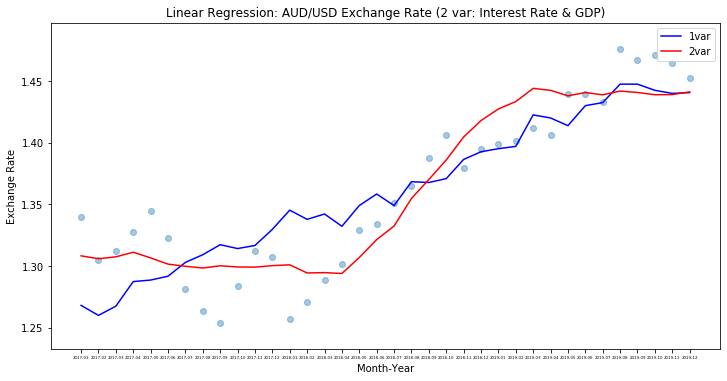

In [10]:
plt.figure(figsize=(12,6))
plt.scatter(month_year, y_fx, alpha=0.4)
plt.plot(month_year, y_fx_predict, color='b')
plt.plot(month_year, y_fx_predict_2, color='r')
plt.legend(['1var', '2var'])
plt.title("Linear Regression: AUD/USD Exchange Rate (2 var: Interest Rate & GDP)")
plt.xlabel("Month-Year")
plt.ylabel("Exchange Rate")
plt.xticks(fontsize=4)
plt.show()

In [11]:
#2.2. Variables: Interest Rates & GDP & CPI 

cpi = pd.read_csv("aus usa cpi difference.csv")
cpi.head()

,Unnamed: 0,AUS_CPI,USA_CPI,CPI_diff
0,2017-01-01,1.7,2.5,-0.8
1,2017-02-01,2.0,2.7,-0.7
2,2017-03-01,2.1,2.4,-0.3
3,2017-04-01,2.1,2.2,-0.1
4,2017-05-01,2.0,1.9,0.1


In [12]:
cpi_diff = cpi['CPI_diff']

x_ir_gdp_cpi = np.array(list(zip(x_ir, gdp_diff, cpi_diff)))
x_ir_gdp_cpi = x_ir_gdp_cpi.astype(np.float)

model.fit(x_ir_gdp_cpi, y_fx)
y_fx_predict_4 = model.predict(x_ir_gdp_cpi)

print(model.score(x_ir_gdp_cpi, y_fx))

0.8735331474821529


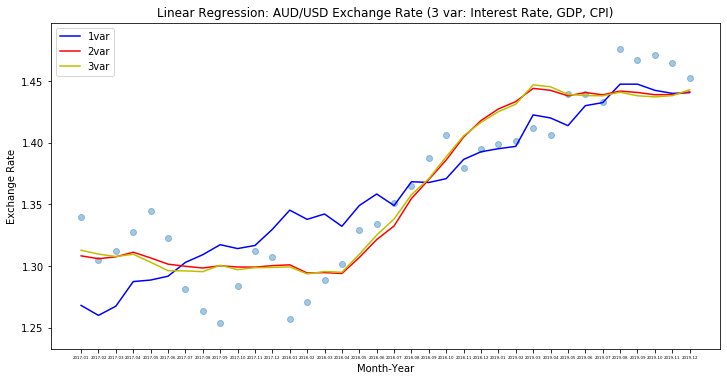

In [13]:
plt.figure(figsize=(12,6))
plt.scatter(month_year, y_fx, alpha=0.4)
plt.plot(month_year, y_fx_predict, color='b')
plt.plot(month_year, y_fx_predict_2, color='r')
plt.plot(month_year, y_fx_predict_4, color='y')
plt.legend(['1var', '2var', '3var'])
plt.title("Linear Regression: AUD/USD Exchange Rate (3 var: Interest Rate, GDP, CPI)")
plt.xlabel("Month-Year")
plt.ylabel("Exchange Rate")
plt.xticks(fontsize=4)
plt.show()

In [14]:
#2.3. Variables: Interest Rates & GDP & UER (replace CPI with UER)

unemployment_rate = pd.read_csv("aus usa unemployment rate.csv")
unemployment_rate.head()

,DATE,aus_unemployment rate,usa_unemployment rate
0,2017-01-01,5.802288,4.697388
1,2017-02-01,6.025591,4.468691
2,2017-03-01,6.040907,4.455698
3,2017-04-01,5.797768,4.406868
4,2017-05-01,5.724388,4.347041


In [15]:
unemployment_rate['uer_diff'] = unemployment_rate['aus_unemployment rate'] - unemployment_rate['usa_unemployment rate']
uer_diff_all = unemployment_rate['uer_diff']
uer_diff = ["%.4f" % num for num in uer_diff_all]

print(uer_diff)

['1.1049', '1.5569', '1.5852', '1.3909', '1.3773', '1.4156', '1.2700', '1.3390', '1.5011', '1.3424', '1.4384', '1.6143', '1.4627', '1.6988', '1.6145', '1.8452', '1.5477', '1.6628', '1.6205', '1.6746', '1.4033', '1.4193', '1.2982', '1.1261', '1.2693', '1.2660', '1.5775', '1.6893', '1.6890', '1.6503', '1.7533', '1.8396', '1.8146', '1.8720', '1.7240', '1.5248']


In [16]:
x_ir_gdp_uer = np.array(list(zip(x_ir, gdp_diff, uer_diff)))
x_ir_gdp_uer = x_ir_gdp_uer.astype(np.float)

model.fit(x_ir_gdp_uer, y_fx)
y_fx_predict_3 = model.predict(x_ir_gdp_uer)

print(model.score(x_ir_gdp_uer, y_fx))

0.8889382199971628


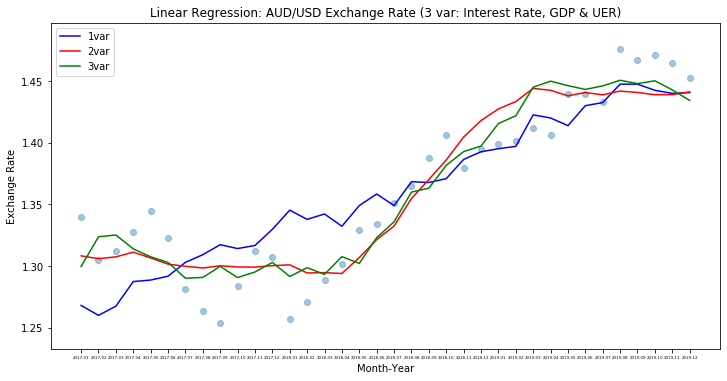

In [17]:
plt.figure(figsize=(12,6))
plt.scatter(month_year, y_fx, alpha=0.4)
plt.plot(month_year, y_fx_predict, color='b')
plt.plot(month_year, y_fx_predict_2, color='r')
plt.plot(month_year, y_fx_predict_3, color='g')
plt.legend(['1var', '2var', '3var'])
plt.title("Linear Regression: AUD/USD Exchange Rate (3 var: Interest Rate, GDP & UER)")
plt.xlabel("Month-Year")
plt.ylabel("Exchange Rate")
plt.xticks(fontsize=4)
plt.show()

In [18]:
#3 Polynomial Regression for the latest model to find the best fit

month_year_future = [x+1 for x in range(0, 12)]
month_year_future = ['2020-0'+ str(x) for x in month_year_future]
print(month_year_future)


['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-010', '2020-011', '2020-012']


In [19]:
Date = range(1, 37)
Date = np.array(Date).reshape(-1,1)

Date_future = range(36, 49)
Date_future = np.array(Date_future).reshape(-1,1)

0.9998889832100238


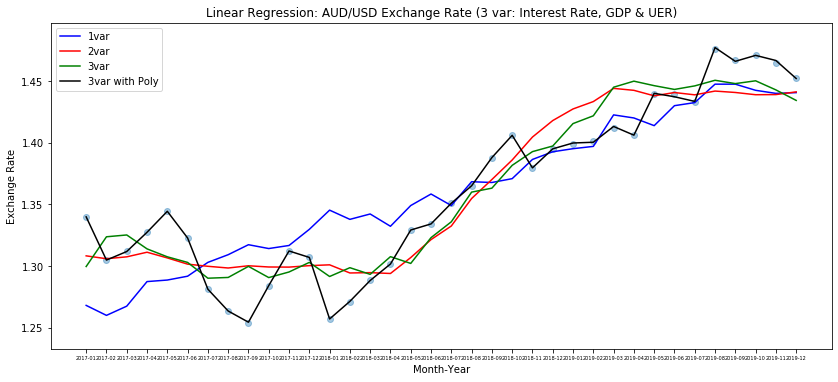

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

poly = PolynomialFeatures(degree=4)

x_poly = poly.fit_transform(x_ir_gdp_uer)

model_poly = LinearRegression()
model_poly.fit(x_poly, y_fx)
y_pred = model_poly.predict(x_poly)

print(model_poly.score(x_poly, y_fx))

plt.figure(figsize=(14,6))
plt.scatter(month_year, y_fx, alpha=0.4)
plt.plot(month_year, y_fx_predict, color='b')
plt.plot(month_year, y_fx_predict_2, color='r')
plt.plot(month_year, y_fx_predict_3, color='g')
plt.plot(month_year, y_pred, color='black')
plt.legend(['1var', '2var', '3var', '3var with Poly'])
plt.title("Linear Regression: AUD/USD Exchange Rate (3 var: Interest Rate, GDP & UER)")
plt.xlabel("Month-Year")
plt.ylabel("Exchange Rate")
plt.xticks(fontsize=5)
plt.show()

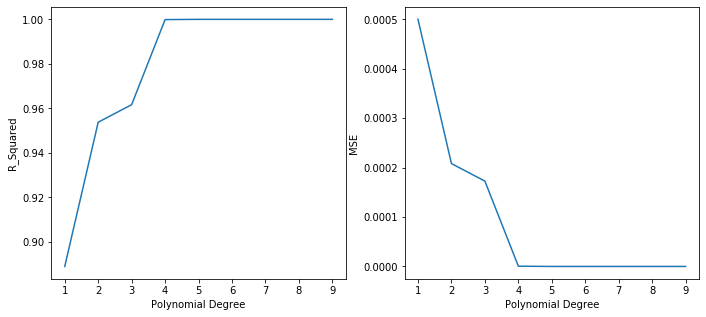

In [21]:
r_squared_list = []
mse_list = []
a = range(1,10,1)

for i in a:
    poly = PolynomialFeatures(degree=i)
    x_poly = poly.fit_transform(x_ir_gdp_uer)
    
    model_poly = LinearRegression()
    model_poly.fit(x_poly, y_fx)
    y_pred = model_poly.predict(x_poly)
    
    r_squared = model_poly.score(x_poly, y_fx)
    mse = mean_squared_error(y_pred, y_fx)
    
    r_squared_list.append(r_squared)
    mse_list.append(mse)

plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
plt.plot(a, r_squared_list)
plt.xlabel("Polynomial Degree")
plt.ylabel("R_Squared")
ax2 = plt.subplot(1,2,2)
plt.plot(a, mse_list)
plt.xlabel("Polynomial Degree")
plt.ylabel("MSE")

plt.subplots_adjust(0.0005)

plt.show()

0.8889378781766654
0.8703105846376484


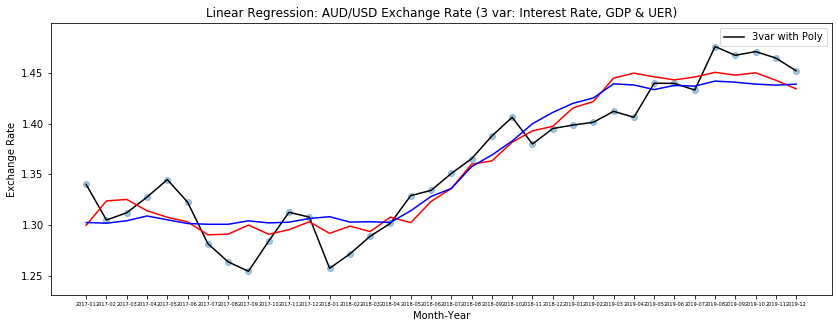

In [22]:
from sklearn.linear_model import Ridge, Lasso

ridge = Ridge(alpha=0.001)
ridge.fit(x_ir_gdp_uer, y_fx)

y_fx_ridge = ridge.predict(x_ir_gdp_uer)
print(ridge.score(x_ir_gdp_uer, y_fx))

lasso = Lasso(alpha=0.001)
lasso.fit(x_ir_gdp_uer, y_fx)

y_fx_lasso = lasso.predict(x_ir_gdp_uer)
print(lasso.score(x_ir_gdp_uer, y_fx))
 
plt.figure(figsize=(14,5))
plt.scatter(month_year, y_fx, alpha=0.4)
plt.plot(month_year, y_pred, color='black')
plt.plot(month_year, y_fx_ridge, color='r')
plt.plot(month_year, y_fx_lasso, color='b')
plt.legend(['3var with Poly'])
plt.title("Linear Regression: AUD/USD Exchange Rate (3 var: Interest Rate, GDP & UER)")
plt.xlabel("Month-Year")
plt.ylabel("Exchange Rate")
plt.xticks(fontsize=5)
plt.show()